In [188]:
# Load anndata object and create pseudobulk for MOFA analysis
# Necessary cell annotations in the anndata object are: 'cluster_id' (giving the cell-type cluster annotations), 'sample_id' (unique identifier of a sample)

# Prerequisites - Load Libraries

In [189]:
import scanpy as sc

In [190]:
import anndata as  ad

In [191]:
import pandas as pd

In [192]:
import random

In [193]:
import numpy as np

In [194]:
import random

In [195]:
import os

In [196]:
import decoupler as dc

In [197]:
ad.__version__

'0.8.0'

In [198]:
print(pd.__version__)

1.5.3


In [199]:
import scanpy as sc
from scipy.sparse import issparse

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

In [201]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

# Preqrequisites Configurations & Parameters

In [202]:
### Load the parameters that are set via the configuration files

In [203]:
### Load configurations file
global_configs = pd.read_csv('configurations/Data_Configs.csv', sep = ',')

In [204]:
global_configs

,parameter,value
0,data_path,/lustre/groups/epigenereg01/workspace/projects...
1,result_path,/lustre/groups/epigenereg01/workspace/projects...


In [205]:
data_path = global_configs['value'][global_configs['parameter'] == 'data_path']

In [206]:
data_path

0    /lustre/groups/epigenereg01/workspace/projects...
Name: value, dtype: object

In [207]:
result_path = global_configs['value'][global_configs['parameter'] == 'result_path']

In [208]:
result_path

1    /lustre/groups/epigenereg01/workspace/projects...
Name: value, dtype: object

In [209]:
## Loading the file containing the name of the single-cell dataset

In [210]:
sc_configs = pd.read_csv('configurations/01_Pre_Processing_SC_Data.csv', sep = ',')

In [211]:
sc_configs

,data_name
0,Prepared_sc_Data


In [212]:
sc_configs = sc_configs[sc_configs['data_name'] != '']

In [213]:
sc_dataset_names = pd.unique(sc_configs['data_name'])

In [214]:
sc_dataset_names

array(['Prepared_sc_Data'], dtype=object)

In [215]:
### Generate the result data directory if it does not exist yet

if not os.path.exists(result_path[1] + '01_results'):
    # Create the directory if it doesn't exist
    os.makedirs(result_path[1] + '01_results')


# Load data

## Anndata object

In [216]:
### Load single-cell datasets as anndata format; should contain the meta-columns: sample_id; cluster_id
### Raw Counts should be given in default assay

In [217]:
sc_data_list = {}

In [218]:
for i in sc_dataset_names:
    source_text = os.path.join(data_path[0], f'{i}.h5ad')
    print(source_text)
    print(os.path.getmtime(source_text))
    adata = ad.read_h5ad(source_text)
    #adata.raw.to_adata()
    
    # Store the loaded Seurat object in the dictionary
    sc_data_list[i] = adata

/lustre/groups/epigenereg01/workspace/projects/jove/input_data/Prepared_sc_Data.h5ad
1715785024.0


In [219]:
adata

AnnData object with n_obs × n_vars = 148275 × 19221
    obs: 'cluster_id', 'sample_id'
    var: 'dispersions', 'dispersions-L1', 'dispersions-L10', 'dispersions-L11', 'dispersions-L12', 'dispersions-L13', 'dispersions-L14', 'dispersions-L2', 'dispersions-L3', 'dispersions-L4', 'dispersions-L5', 'dispersions-L6', 'dispersions-L7', 'dispersions-L8', 'dispersions-L9', 'dispersions_norm', 'dispersions_norm-L1', 'dispersions_norm-L10', 'dispersions_norm-L11', 'dispersions_norm-L12', 'dispersions_norm-L13', 'dispersions_norm-L14', 'dispersions_norm-L2', 'dispersions_norm-L3', 'dispersions_norm-L4', 'dispersions_norm-L5', 'dispersions_norm-L6', 'dispersions_norm-L7', 'dispersions_norm-L8', 'dispersions_norm-L9', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'highly_variable-L1', 'highly_variable-L10', 'highly_variable-L11', 'highly_variable-L12', 'highly_variable-L13', 'highly_variable-L14', 'highly_variable-L2', 'highly_variable-L3', 'highly_variable-L4', 'highly_variable-L5', 'h

In [220]:
adata.obs

,cluster_id,sample_id
AAACCCACATACAGGG-1-L1,B cell,m9.1
AAACCCACATGACTTG-1-L1,CD16 Mono,m9.1
AAACCCAGTCATCAGT-1-L1,CD4 TCM,m7.1
AAACCCAGTGGTAATA-1-L1,CD4 TCM,m9.1
AAACCCATCATCACAG-1-L1,Plasmablast,m9.1
...,...,...
TTTGTTGCAGGTTCGC-1-L14,CD4 TCM,m26.4
TTTGTTGGTACCTAGT-1-L14,CD4 TEM,m22.4
TTTGTTGGTACGTTCA-1-L14,CD14 Mono,m23.4
TTTGTTGGTGGACCAA-1-L14,CD14 Mono,m28.4


# Data-Checks

In [221]:
# Optional execute some checks to see whether raw counts will be used

## Check amount of cells per sample and cluster

In [222]:
cell_counts_per_cluster = {key: pd.crosstab(value.obs['cluster_id'], value.obs['cluster_id']).sum(axis=1) for key, value in sc_data_list.items()}

In [223]:
### Amount of cells per cluster
cell_counts_per_cluster

{'Prepared_sc_Data': cluster_id
 ASDC                     8
 B cell                9829
 CD4 CTL               2346
 CD4 Naive             6495
 CD4 Proliferating      108
 CD4 TCM              45102
 CD4 TEM               6296
 CD8 Naive             2612
 CD8 Proliferating       13
 CD8 TCM                525
 CD8 TEM              10611
 CD14 Mono            32727
 CD16 Mono             4680
 Doublet                 48
 Eryth                    6
 HSPC                   332
 ILC                    931
 MAIT                  1177
 NK                   15699
 NK Proliferating       168
 NK_CD56bright          874
 Plasmablast            703
 Platelet               450
 Treg                  2362
 cDC1                    83
 cDC2                  1314
 dnT                    130
 gdT                   1901
 pDC                    745
 dtype: int64}

In [224]:
### Save the result as a dataframe for usage in the next script
cells_per_sample_cluster = {key: pd.crosstab(value.obs['cluster_id'], value.obs['sample_id']).T for key, value in sc_data_list.items()}

In [225]:
# Convert the dictionary of DataFrames into a single DataFrame and melt it to long format
cells_per_sample_cluster_long = pd.concat({key: value.melt(ignore_index=False) for key, value in cells_per_sample_cluster.items()})

# Reset index and rename columns
cells_per_sample_cluster_long.reset_index(inplace=True)
cells_per_sample_cluster_long.columns = ['dataset', 'Sample', 'Cluster_Cell_Type', 'amount_cells']

In [226]:
cells_per_sample_cluster_long

,dataset,Sample,Cluster_Cell_Type,amount_cells
0,Prepared_sc_Data,k2,ASDC,0
1,Prepared_sc_Data,k3,ASDC,0
2,Prepared_sc_Data,k4,ASDC,0
3,Prepared_sc_Data,k5,ASDC,0
4,Prepared_sc_Data,k6,ASDC,0
...,...,...,...,...
3446,Prepared_sc_Data,m27.2,pDC,7
3447,Prepared_sc_Data,m27.3,pDC,12
3448,Prepared_sc_Data,m28.2,pDC,2
3449,Prepared_sc_Data,m28.3,pDC,3


In [227]:
## Save the file
for i in pd.unique(cells_per_sample_cluster_long['dataset']):
    save_data = cells_per_sample_cluster_long[cells_per_sample_cluster_long['dataset'] == i]
    save_data.to_csv(result_path[1] + '01_results/01_' + i +  '_Cell_Sample_Cluster_Distribution.csv')

In [228]:
## Categorize the amount of cells

In [229]:
# Define bins and labels
bins = [-np.inf, 3, 10, 20, 50, np.inf]
labels = ['0-3', '3-10', '10-20', '20-50', '> 50']
# Map amount_cells to categories
cells_per_sample_cluster_long['amount_cells_cat'] = pd.cut(cells_per_sample_cluster_long['amount_cells'], bins=bins, labels=labels, right=False)

In [230]:
cells_per_sample_cluster_long

,dataset,Sample,Cluster_Cell_Type,amount_cells,amount_cells_cat
0,Prepared_sc_Data,k2,ASDC,0,0-3
1,Prepared_sc_Data,k3,ASDC,0,0-3
2,Prepared_sc_Data,k4,ASDC,0,0-3
3,Prepared_sc_Data,k5,ASDC,0,0-3
4,Prepared_sc_Data,k6,ASDC,0,0-3
...,...,...,...,...,...
3446,Prepared_sc_Data,m27.2,pDC,7,3-10
3447,Prepared_sc_Data,m27.3,pDC,12,10-20
3448,Prepared_sc_Data,m28.2,pDC,2,0-3
3449,Prepared_sc_Data,m28.3,pDC,3,3-10


In [231]:
# Visualized the result

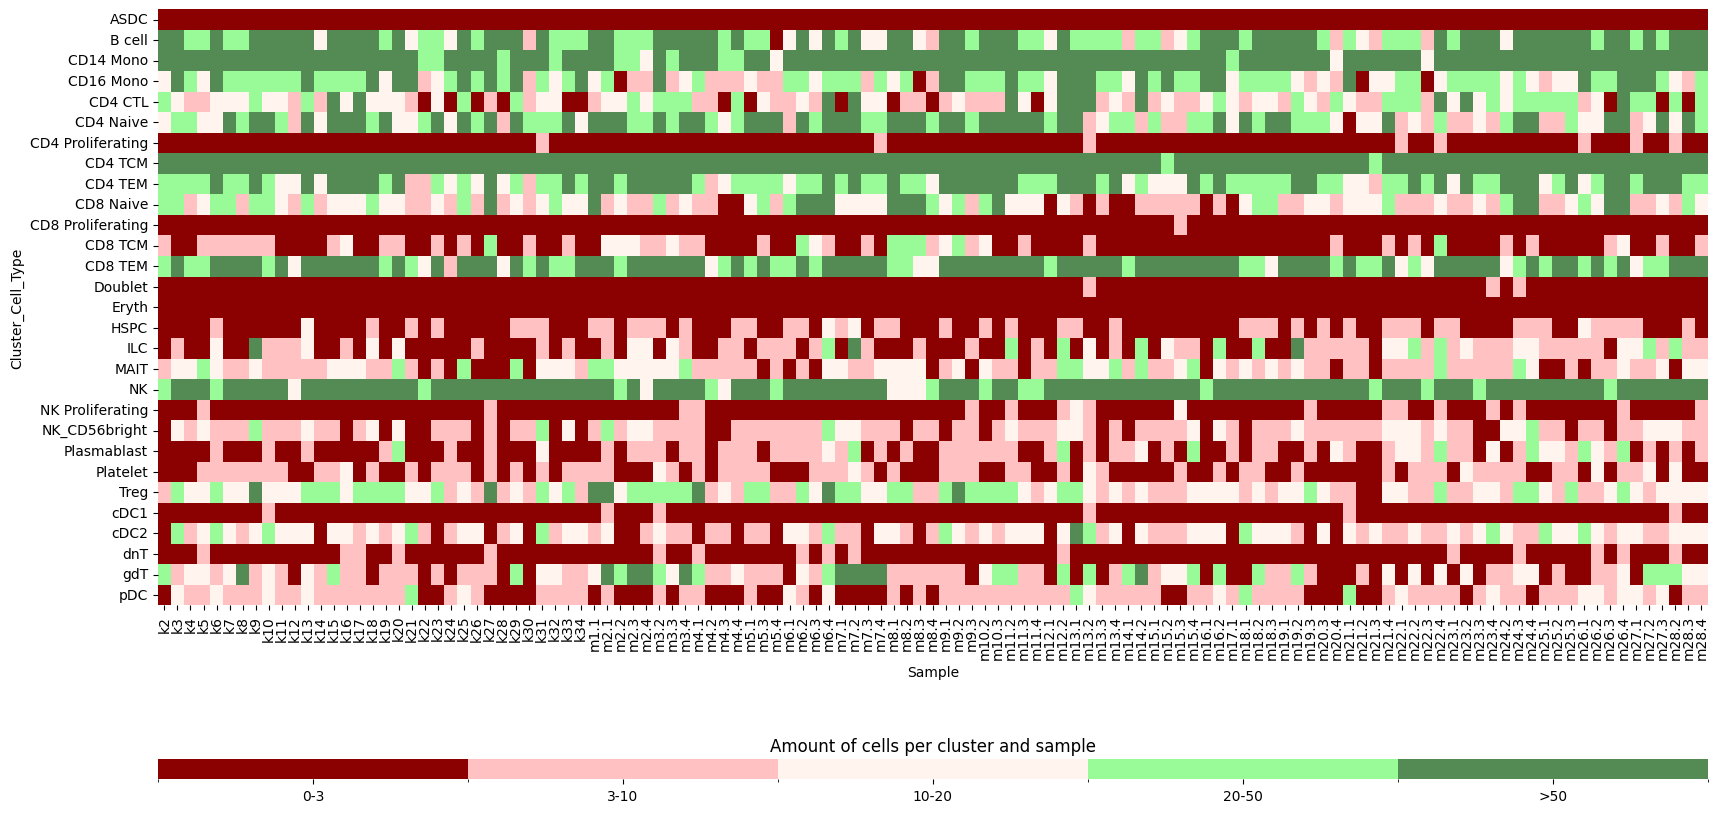

In [232]:
my_colors = ['#8B0000', '#FFC1C1', '#FFF5EE', '#98FB98', '#548B54']
my_cmap = ListedColormap(my_colors)

bounds = [0, 3, 10, 20, 50, 10000]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

#grid_kws = {"height_ratios": (1), "hspace": .1}
# Adjust figsize for a less long and wider plot
fig, (ax, cbar_ax) = plt.subplots(nrows=2, figsize=(20, 10), gridspec_kw={"height_ratios": (15, 0.5), "hspace": .5})
sns.heatmap(data=cells_per_sample_cluster_long.pivot(index='Cluster_Cell_Type', columns='Sample', values='amount_cells'),
            #yticklabels=2, 
            ax=ax,
            cmap=my_cmap,
            norm=my_norm,
            cbar_ax=cbar_ax, xticklabels=True, yticklabels=True,
            cbar_kws={"orientation": "horizontal",  "pad": 0.05})


colorbar = ax.collections[0].colorbar
colorbar.set_ticks([(b0+b1)/2 for b0, b1 in zip(bounds[:-1], bounds[1:])])
colorbar.set_ticklabels(['0-3', '3-10', '10-20', '20-50', '>50'])

# Add title
plt.title("Amount of cells per cluster and sample")

# Save the figure as a PDF to a specific folder
plt.savefig('figures/01_figures/FIG01_Amount_of_Cells_per_Sample_and_Cell_Type'  + '.pdf', bbox_inches='tight')
plt.show()

## Calculate gene expression percentages per cluster for thresholding

In [233]:
### Calculate the percentage of cells having non-zero values for each gene per cluster
### will later be used to remove genes that are only expressed in a very low amount of cells

In [234]:
## Generate empty data.frames to store the result in

In [235]:
gene_expr_data = pd.DataFrame()

In [236]:
for j in sc_data_list.keys():
    adata = sc_data_list[j]
    
    for i in pd.unique(adata.obs['cluster_id']):
        cell_type = i
        adata_subset = adata[adata.obs['cluster_id'] == cell_type]

        amount_cells = adata_subset.shape[0]
        ## Calcalte percentage of cells expressiong gene
        amount_cells_expressing_gene = (adata_subset.X > 0).sum(axis= 0)
        perc_cells_expressing_gene = (amount_cells_expressing_gene/ amount_cells) * 100

        data = {
        'perc_cells_expressing_gene': np.ravel(perc_cells_expressing_gene),
        'total_amount_cells_expressing_gene': np.ravel(amount_cells_expressing_gene),
        'gene': adata_subset.var_names,
        'cluster': cell_type,
        'dataset': j
        }

        df = pd.DataFrame(data)

        ### Append data
        gene_expr_data = pd.concat([gene_expr_data, df])

In [237]:
gene_expr_data

,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster,dataset
0,0.234001,23,AL627309.1,B cell,Prepared_sc_Data
1,0.061044,6,AL627309.4,B cell,Prepared_sc_Data
2,6.775867,666,AL669831.5,B cell,Prepared_sc_Data
3,0.122088,12,FAM87B,B cell,Prepared_sc_Data
4,1.678706,165,LINC00115,B cell,Prepared_sc_Data
...,...,...,...,...,...
19216,0.000000,0,AL592183.1,Eryth,Prepared_sc_Data
19217,0.000000,0,AC007325.4,Eryth,Prepared_sc_Data
19218,0.000000,0,AL354822.1,Eryth,Prepared_sc_Data
19219,0.000000,0,AC004556.1,Eryth,Prepared_sc_Data


In [238]:
### Save results for later filtering
for i in pd.unique(gene_expr_data['dataset']):
    save_data = gene_expr_data[gene_expr_data['dataset'] == i]
    save_data.to_csv(result_path[1] + '/01_results/01_'  + i +  '_Gene_Expr_per_Cell_Type' +  '.csv')

## Aggregate to pseudobulk

In [239]:
## Aggregate to pseudobulk by cluster and sample_id

In [240]:
adata.raw

In [241]:
for j in sc_data_list.keys():
    adata = sc_data_list[j]
    adata = dc.get_pseudobulk(
        adata,
        sample_col='sample_id',
        groups_col='cluster_id',
        #layer='counts',
        mode='mean',
        min_cells=0,  # Filter to remove samples by a minimum number of cells in a sample-group pair.
        min_counts=0)   
    
    ## Format as table 
    
    data = adata.to_df()
    data['feature'] = data.index
    
    ## Convert to long format
    data_long = pd.melt(data, id_vars = ['feature'])
    data_long['sample_id'] = data_long['feature'].str.extract(r'^([^_]*)')
    data_long['type'] = data_long['feature'].str.extract(r'_(.*)')
    
    data_long['variable'] = data_long['variable']
    data_long['dataset'] = sc_dataset_names[0]
    
    ## Select relevant columns and save
    data_long = data_long[['sample_id', 'variable', 'value', 'dataset', 'type']]
    data_long.to_csv(result_path[1] + '/01_results/01_' + j + 'Pseudobulk_Table' +'.csv')

In [242]:
data_long

,sample_id,variable,value,dataset,type
0,k18,A1BG,2.000000,Prepared_sc_Data,ASDC
1,m19.2,A1BG,0.000000,Prepared_sc_Data,ASDC
2,m21.4,A1BG,1.000000,Prepared_sc_Data,ASDC
3,m22.2,A1BG,0.000000,Prepared_sc_Data,ASDC
4,m25.2,A1BG,0.000000,Prepared_sc_Data,ASDC
...,...,...,...,...,...
51089413,m8.3,ZZEF1,0.000000,Prepared_sc_Data,pDC
51089414,m8.4,ZZEF1,0.500000,Prepared_sc_Data,pDC
51089415,m9.1,ZZEF1,0.666667,Prepared_sc_Data,pDC
51089416,m9.2,ZZEF1,0.250000,Prepared_sc_Data,pDC


In [243]:
len(pd.unique(data_long['sample_id']))

119